In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("/kaggle/input"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install xgboost

In [3]:
# df = pd.read_csv("/kaggle/input/hahe-statistics-all-programmes/hahe_all_21_24.csv")
df = pd.read_csv("hahe_all_21_24.csv")

In [4]:
df.head()

,institution,academic_year,program,established,graduate,registered,enrolled,active
0,Athens School of Fine Arts,2020-2021,Fine Arts,03/07/1990,99,1570,140,983
1,Athens School of Fine Arts,2020-2021,Art Theory and History,07/09/2009,116,577,83,443
2,Aristotle University of Thessaloniki,2020-2021,English Language and Literature,03/05/1983,223,1557,227,806
3,Aristotle University of Thessaloniki,2020-2021,Agricultural and Surveying Engineering,24/10/1962,75,937,125,593
4,Aristotle University of Thessaloniki,2020-2021,Architectural Engineering,03/05/1983,142,1297,161,973


In [5]:
target = "graduate"

features = ["institution", "program", "registered", "enrolled", "active"]

# Random Forest

In [6]:
df_rf = df.copy()

train_df_rf = df_rf[df_rf["academic_year"] != "2023-2024"]
test_df_rf = df_rf[df_rf["academic_year"] == "2023-2024"]

X_train_rf = train_df_rf[features]
y_train_rf = train_df_rf[target]

X_test_rf = test_df_rf[features]
y_test_rf = test_df_rf[target]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

categorical = ["institution", "program"]
numerical = ["registered", "enrolled", "active"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

model = RandomForestRegressor(n_estimators=300, random_state=42)

pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", model)])

pipeline.fit(train_df_rf, y_train_rf)
y_pred_rf = pipeline.predict(X_test_rf)

from sklearn.metrics import mean_absolute_error, r2_score

print("MAE:", mean_absolute_error(y_test_rf, y_pred_rf))
print("R²:", r2_score(y_test_rf, y_pred_rf))

MAE: 27.62626598235188
R²: 0.7511178082527201


# XGBoost

In [7]:
df_xgb = df.copy()

train_df_xgb = df_xgb[df_xgb["academic_year"] != "2023-2024"]
test_df_xgb = df_xgb[df_xgb["academic_year"] == "2023-2024"]

X_train_xgb = train_df_xgb[features]
y_train_xgb = train_df_xgb[target]

X_test_xgb = test_df_xgb[features]
y_test_xgb = test_df_xgb[target]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

pipeline = Pipeline([("preprocess", preprocessor), ("model", xgb_model)])

pipeline.fit(X_train_xgb, y_train_xgb)
y_pred_xgb = pipeline.predict(X_test_xgb)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test_xgb, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb)))
print("R²:", r2_score(y_test_xgb, y_pred_xgb))

MAE: 26.35228157043457
RMSE: 40.342270378560436
R²: 0.773658812046051


# Time aware model (XGBoost)

In [8]:
df_time_aware = df.copy()
df_time_aware = df_time_aware.sort_values(
    by=["institution", "program", "academic_year"]
)

df_time_aware["graduate_lag_1"] = df_time_aware.groupby(["institution", "program"])[
    "graduate"
].shift(1)

df_time_aware["graduate_lag_2"] = df_time_aware.groupby(["institution", "program"])[
    "graduate"
].shift(2)

df_time_aware["graduate_growth"] = (
    df_time_aware["graduate_lag_1"] - df_time_aware["graduate_lag_2"]
) / df_time_aware["graduate_lag_2"]

df_time_aware = df_time_aware.replace([np.inf, -np.inf], np.nan)
df_time_aware = df_time_aware.dropna().reset_index(
    drop=True
)  # Drop NaN values since they indicate no historical information

train_df_time_aware = df_time_aware[df_time_aware["academic_year"] != "2023-224"]
test_df_time_aware = df_time_aware[df_time_aware["academic_year"] == "2023-2024"]

features_time_aware = [
    "institution",
    "program",
    "registered",
    "enrolled",
    "active",
    "graduate_lag_1",
    "graduate_lag_2",
    "graduate_growth",
]


X_train_time_aware = train_df_time_aware[features_time_aware]
y_train_time_aware = train_df_time_aware[target]

X_test_time_aware = test_df_time_aware[features_time_aware]
y_test_time_aware = test_df_time_aware[target]

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

categorical = ["institution", "program"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
)

pipeline = Pipeline([("preprocess", preprocessor), ("model", xgb_model)])

pipeline.fit(X_train_time_aware, y_train_time_aware)
y_pred_time_aware = pipeline.predict(X_test_time_aware)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test_time_aware, y_pred_time_aware)
rmse = np.sqrt(mean_squared_error(y_test_time_aware, y_pred_time_aware))
r2 = r2_score(y_test_time_aware, y_pred_time_aware)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.3f}")

MAE  : 11.98
RMSE : 15.47
R²   : 0.968


In [9]:
# Compare against a naive baseline
baseline_pred = X_test_time_aware["graduate_lag_1"]

from sklearn.metrics import mean_absolute_error, r2_score

print("Baseline MAE:", mean_absolute_error(y_test_time_aware, baseline_pred))
print("Baseline R² :", r2_score(y_test_time_aware, baseline_pred))

Baseline MAE: 39.90413533834587
Baseline R² : 0.4322106846281206


Remove lag 1 and retrain the model (?)

# Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Copy dataframe
df_linear = df.copy()

# Split data
train_df_linear = df_linear[df_linear["academic_year"] != "2023-2024"]
test_df_linear = df_linear[df_linear["academic_year"] == "2023-2024"]

# Features and target
features = ["institution", "program", "enrolled", "registered", "active"]
target = "graduate"

X_train_linear = train_df_linear[features]
y_train_linear = train_df_linear[target]

X_test_linear = test_df_linear[features]
y_test_linear = test_df_linear[target]

# Preprocessing
categorical = ["institution", "program"]
numerical = ["enrolled", "registered", "active"]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", "passthrough", numerical),
    ]
)

# -----------------------------
# Linear Regression
# -----------------------------
linear_model = Pipeline(
    [("preprocessing", preprocessor), ("regressor", LinearRegression())]
)

linear_model.fit(X_train_linear, y_train_linear)
y_pred_linear = linear_model.predict(X_test_linear)

mse_linear = mean_squared_error(y_test_linear, y_pred_linear)
r2_linear = r2_score(y_test_linear, y_pred_linear)

print("Linear Regression:")
print(f"  MSE: {mse_linear:.2f}")
print(f"  R² : {r2_linear:.3f}\n")

# -----------------------------
# Ridge Regression
# -----------------------------
ridge_model = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("regressor", Ridge(alpha=1.0)),  # alpha is regularization strength
    ]
)

ridge_model.fit(X_train_linear, y_train_linear)
y_pred_ridge = ridge_model.predict(X_test_linear)

mse_ridge = mean_squared_error(y_test_linear, y_pred_ridge)
r2_ridge = r2_score(y_test_linear, y_pred_ridge)

print("Ridge Regression:")
print(f"  MSE: {mse_ridge:.2f}")
print(f"  R² : {r2_ridge:.3f}\n")

# -----------------------------
# Lasso Regression
# -----------------------------
lasso_model = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("regressor", Lasso(alpha=0.1)),  # alpha is regularization strength
    ]
)

lasso_model.fit(X_train_linear, y_train_linear)
y_pred_lasso = lasso_model.predict(X_test_linear)

mse_lasso = mean_squared_error(y_test_linear, y_pred_lasso)
r2_lasso = r2_score(y_test_linear, y_pred_lasso)

print("Lasso Regression:")
print(f"  MSE: {mse_lasso:.2f}")
print(f"  R² : {r2_lasso:.3f}")

Linear Regression:
  MSE: 1933.20
  R² : 0.731

Ridge Regression:
  MSE: 2897.99
  R² : 0.597

Lasso Regression:
  MSE: 2046.16
  R² : 0.715


# SVR

In [11]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler


df_svr = df.copy()

train_df_svr = df_svr[df_svr["academic_year"] != "2023-2024"]
test_df_svr = df_svr[df_svr["academic_year"] == "2023-2024"]

features = ["institution", "program", "enrolled", "registered", "active"]
target = "graduate"

X_train_svr = train_df_svr[features]
y_train_svr = train_df_svr[target]

X_test_svr = test_df_svr[features]
y_test_svr = test_df_svr[target]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
        ("num", StandardScaler(), numerical),
    ]
)

svr_model = Pipeline(
    [
        ("preprocessing", preprocessor),
        ("regressor", SVR(kernel="rbf", C=1.0, epsilon=0.1)),
    ]
)

svr_model.fit(X_train_svr, y_train_svr)

y_pred_svr = svr_model.predict(X_test_svr)

mse_svr = mean_squared_error(y_test_svr, y_pred_svr)
r2_svr = r2_score(y_test_svr, y_pred_svr)

print("Support Vector Regression (SVR):")
print(f"  MSE: {mse_svr:.2f}")
print(f"  R² : {r2_svr:.3f}")

Support Vector Regression (SVR):
  MSE: 4361.05
  R² : 0.393


In [12]:
df

,institution,academic_year,program,established,graduate,registered,enrolled,active
0,Athens School of Fine Arts,2020-2021,Fine Arts,03/07/1990,99,1570,140,983
1,Athens School of Fine Arts,2020-2021,Art Theory and History,07/09/2009,116,577,83,443
2,Aristotle University of Thessaloniki,2020-2021,English Language and Literature,03/05/1983,223,1557,227,806
3,Aristotle University of Thessaloniki,2020-2021,Agricultural and Surveying Engineering,24/10/1962,75,937,125,593
4,Aristotle University of Thessaloniki,2020-2021,Architectural Engineering,03/05/1983,142,1297,161,973
...,...,...,...,...,...,...,...,...
2446,Hellenic Naval Academy,2023-2024,Naval Sciences,07/10/2003,43,188,84,188
2447,Harokopio University,2023-2024,Geography,06/09/1999,79,1012,108,511
2448,Harokopio University,2023-2024,Dietology - Nutrition Science,12/06/1992,89,713,89,467
2449,Harokopio University,2023-2024,Economy and Sustainable Development (formerly ...,12/06/1992,75,716,104,466


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ institution         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ program             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ academic_year       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 15)     │        420 │ institution[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 1, 50)     │     13,900 │ program[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 1, 3)      │         12 │ academic_year[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 15)        │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 50)        │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 3)         │          0 │ embedding_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric_input       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 72)        │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ flatten_4[0][0],  │
│                     │                   │            │ flatten_5[0][0],  │
│                     │                   │            │ numeric_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      9,344 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 31,997 (124.99 KB)

 Trainable params: 31,997 (124.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 16409.1074 - mae: 88.0115 - val_loss: 14141.1377 - val_mae: 86.4906
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12111.0986 - mae: 73.1271 - val_loss: 5918.6216 - val_mae: 52.5298
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4814.5586 - mae: 48.3564 - val_loss: 3014.7056 - val_mae: 40.0648
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3441.4468 - mae: 40.1722 - val_loss: 2898.9773 - val_mae: 39.1626
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3219.2229 - mae: 38.7975 - val_loss: 2962.3887 - val_mae: 39.5359
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3120.4646 - mae: 37.8648 - val_loss: 2983.7112 - val_mae: 40.2729
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3015.2520 - mae: 37.5564 - val_loss: 3091.4424 - val_mae: 41.0018
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3014.1052 - mae: 37.2333 - val_loss: 3126.0425 - val_mae: 41.7010
Epoch

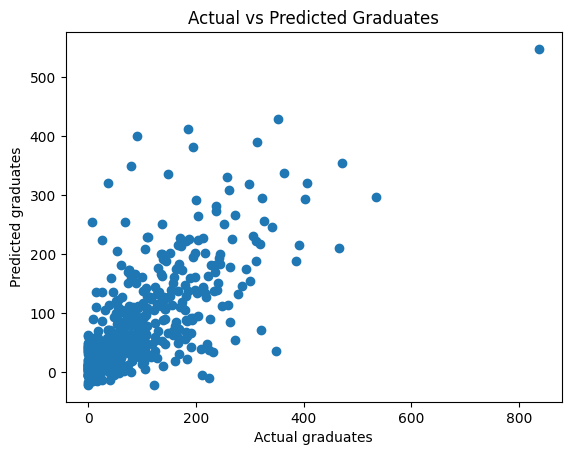

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Embedding,
    Flatten,
    Concatenate,
    Dropout,
)

# --- 1️⃣ Copy the dataframe ---
df_nn = df.copy()

# --- 2️⃣ Feature engineering ---
df_nn["established"] = pd.to_datetime(df_nn["established"], dayfirst=True)
df_nn["years_since_established"] = (
    df_nn["academic_year"].str[:4].astype(int) - df_nn["established"].dt.year
)
df_nn["graduate_rate"] = df_nn["graduate"] / df_nn["enrolled"]

# Fill missing values if any
df_nn.fillna(0, inplace=True)

# --- 3️⃣ Prepare categorical features ---
cat_cols = ["institution", "program", "academic_year"]
cat_maps = {}
for col in cat_cols:
    df_nn[col] = df_nn[col].astype("category")
    df_nn[col + "_id"] = df_nn[col].cat.codes
    cat_maps[col] = dict(enumerate(df_nn[col].cat.categories))

# --- 4️⃣ Prepare numeric features ---
num_cols = ["registered", "enrolled", "active", "years_since_established"]
X_num = df_nn[num_cols].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Target
y = df_nn["graduate"].values

# --- 5️⃣ Split train/test ---
X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_num_scaled, y, test_size=0.2, random_state=42
)

# Split categorical IDs
cat_ids = [df_nn[col + "_id"].values for col in cat_cols]
X_train_cat = [x[: len(X_train_num)] for x in cat_ids]
X_test_cat = [x[len(X_train_num) :] for x in cat_ids]

# --- 6️⃣ Build neural network with embeddings ---
embedding_sizes = {
    "institution": min(50, len(cat_maps["institution"]) // 2 + 1),
    "program": min(50, len(cat_maps["program"]) // 2 + 1),
    "academic_year": min(10, len(cat_maps["academic_year"]) // 2 + 1),
}

# Inputs and embeddings
inputs_cat = []
embeddings = []

for col in cat_cols:
    n_unique = len(cat_maps[col])
    emb_size = embedding_sizes[col]
    inp = Input(shape=(1,), name=col)
    emb = Embedding(input_dim=n_unique, output_dim=emb_size)(inp)
    emb = Flatten()(emb)
    inputs_cat.append(inp)
    embeddings.append(emb)

# Numeric input
input_num = Input(shape=(X_num_scaled.shape[1],), name="numeric_input")

# Combine embeddings + numeric
x = Concatenate()(embeddings + [input_num])
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
output = Dense(1)(x)  # regression output

model = Model(inputs=inputs_cat + [input_num], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# --- 7️⃣ Train the model ---
history = model.fit(
    X_train_cat + [X_train_num], y_train, validation_split=0.2, epochs=50, batch_size=32
)

# --- 8️⃣ Evaluate ---
loss, mae = model.evaluate(X_test_cat + [X_test_num], y_test)
print("Test MAE:", mae)

# --- 9️⃣ Plot predictions ---
y_pred = model.predict(X_test_cat + [X_test_num])
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred)
plt.xlabel("Actual graduates")
plt.ylabel("Predicted graduates")
plt.title("Actual vs Predicted Graduates")
plt.show()